# Assignment 2 - Data from the web

## Data scraping

## 1. Obtain all the data

In [30]:
%matplotlib inline
import requests
import pandas as pd
import numpy as np
import math
import os
import os.path
import re
import matplotlib.pyplot as plt
from IPython.display import display
from bs4 import BeautifulSoup
from scipy import stats

The first thing to do is to get the base URL (basically looking at the address bar of the browser).
We need a second variable INDEX_PARAM because this page is using frames, and we'll need the base address to access them.

In [31]:
BASE_URL = "http://isa.epfl.ch/imoniteur_ISAP/%21gedpublicreports.htm"
INDEX_PARAM = "ww_i_reportmodel=133685247"

Then let's fetch the parameters names, but as it is a bit tricker, BeautifulSoup will be a great help for this (and also some manual html inspection).

In [32]:
r = requests.get(BASE_URL + '?' + INDEX_PARAM)
soup = BeautifulSoup(r.text, 'html.parser')


#print(soup)

for frame in soup.find_all('frame'):
    if frame['name'] == 'toc':
        r = requests.get("http://isa.epfl.ch/imoniteur_ISAP/" + frame['src'])
        print(frame['src'])
# The content of the frame

# Print slects
soup = BeautifulSoup(r.text, 'html.parser')
query = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247'
    


!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247


For convenience, we also create another function that builds the query from some desired parameters.

In [33]:
def build_query(section, startYear, endYear, semesterType, semesterNumber, semesterSeason):
    # Print slects
    soup = BeautifulSoup(r.text, 'html.parser')
    query = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247'


    for in_put in soup.findAll('input'):
        #print (in_put['name'])
        if in_put.text == "xls":
        #print(in_put['value'])
            query = query + '&' + in_put['name'] + '=' + in_put['value']
     
    for select in soup.findAll('select'):
    #print (select['name'])
        for t in select.findAll('option'):
        #print(t)
            if t.text == section:
            #print(t['value'])
                query = query + '&' + select['name'] + '=' + t['value']
            if t.text == str(startYear) + '-' + str(endYear):
                query = query + '&' + select['name'] + '=' + t['value']
            if t.text == semesterType + " " + str(semesterNumber):
                query = query + '&' + select['name'] + '=' + t['value']
            if t.text == "Semestre " + semesterSeason:
                query = query + '&' + select['name'] + '=' + t['value']
    return query


And finally a nice function to easily query the EPFL page and get the data from it.

In [34]:
DATA_FOLDER_PATH = 'Data/'
os.makedirs(DATA_FOLDER_PATH, exist_ok=True) #creates folder it it doesn't exist
COLUMNS_NAMES = ["civility", "name", "bachelor_orientation", "master_orientation", "specialisation", "optional_spec", "minor", "status", "exchange_type", "exchange_school", "sciper"]
def query_epfl(section, startYear, endYear, semesterType, semesterNumber, semesterSeason, update = False, writeToFile = True):
    #we create files to save the queries (and network bandwidth)
    path = str(section) + str(startYear) + str(endYear) + str(semesterType) + str(semesterNumber) + str(semesterSeason)
    
    #to avoid file naming issues
    path = re.sub('[^A-Za-z0-9]+', '', path)
    path += ".xls"
    
    df = None
    #we query the epfl server only if the file does not exist, or if we want to update the data
    if(not os.path.isfile(DATA_FOLDER_PATH + path) or update):
        queryString = build_query(section, startYear, endYear, semesterType, semesterNumber, semesterSeason)
        response = requests.get(queryString, stream=True)
        if response.status_code == 200:
            data = pd.read_html(response.text, match='.+', flavor=None, header=1, index_col=None, skiprows=1)
            df = data[0]
            df.drop(df.columns[[11, 12]], axis=1, inplace=True) #remove useless columns (all are empty)
            df.columns = COLUMNS_NAMES
            
            #cleaning the invalid rows (basically mapping the scipers to real numbers and remove the non-number rows)
            scipers = df['sciper']
            df = df.drop('sciper', axis=1)
            df = df.join(scipers.apply(pd.to_numeric, errors='coerce'))
            df = df[~df.sciper.isnull()]
            
            if writeToFile:
                df.to_excel(DATA_FOLDER_PATH + path) #save to xls file
    else:
        df = pd.read_excel(DATA_FOLDER_PATH + path, sheetname=0, header=0)
    
    return df

We can now start using those functions to collect data. 
Example below:

In [35]:
test = query_epfl("Informatique", 2007,2008, "Bachelor semestre", 3, "d'automne")
test.head()

,civility,name,bachelor_orientation,master_orientation,specialisation,optional_spec,minor,status,exchange_type,exchange_school,sciper
0,Monsieur,Aapro Niccolò,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,170617.0
1,Monsieur,Arn Patrick,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,174454.0
2,Monsieur,Balas Martin,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,174774.0
3,Monsieur,Bandelier Matthieu,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,173962.0
4,Monsieur,Bindschaedler Laurent,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,170654.0


We're now going to collect and merge every single semester of every single year. We'll append columns "year", "semester".

Together with a student's sciper, we'll use this to make unique indexes. We could've used the name but it's possible that two students with the same name would be in the same class in the same year and semestre.

In [36]:
frames = []
for year in range(2007, 2017):
    for semester in range (1, 7):
        if(semester % 2 == 0 ):
            season="de printemps"
        else:
            season="d'automne"
            
        df = query_epfl("Informatique", year,year+1, "Bachelor semestre", semester, season)
        df['year'] = year
        df['semester'] = semester
        #we use semester as first index for simplicity of use in next part
        df.set_index(['semester', 'year', 'sciper'], drop=False, append=False, inplace=True)
        if (not df.index.is_unique):
            print("Error: non unique index in year:" + str(year) + "-" + str(year+1) + ", semester:" + str(semester) + ", season:" + str(season))
            
        frames.append(df)

bStudents = pd.concat(frames)
bStudents.shape

(5808, 13)

We make sure the index is unique

In [37]:
bStudents.index.is_unique

True

For better readability, we now drop all columns that are completely empty

In [38]:
bStudents = bStudents.dropna(axis=1, how='all')

In [39]:
bStudents.head()

civility                name optional_spec   status  \
semester year sciper                                                          
1        2007 169569.0  Monsieur   Arévalo Christian           NaN  Présent   
              174905.0  Monsieur     Aubelle Flavien           NaN  Présent   
              173922.0  Monsieur       Badoud Morgan           NaN  Présent   
              179406.0  Monsieur  Baeriswyl Jonathan           NaN  Présent   
              179428.0  Monsieur     Barroco Michael           NaN  Présent   

                       exchange_type exchange_school    sciper  year  semester  
semester year sciper                                                            
1        2007 169569.0           NaN             NaN  169569.0  2007         1  
              174905.0           NaN             NaN  174905.0  2007         1  
              173922.0           NaN             NaN  173922.0  2007         1  
              179406.0           NaN             NaN  179406.0  2007         1  
              179428.0           NaN             NaN  179428.0  2007         1

With this very nice table, we still need the keep the students present in semester 1 and semester 6 only (and also filter out the columns we don't need).

In [40]:
bStudentsS1toS6 = pd.merge(bStudents.loc[1], bStudents.loc[6], how='inner', on=['civility', 'name', 'sciper'], suffixes=('_S1', '_S6'))
bStudentsS1toS6 = bStudentsS1toS6[['civility', 'sciper', 'year_S1', 'year_S6']] #only retain the important fields

bStudentsS1toS6['year_S6'] += 1 #we do this because the last year is not the graduation year, but when it started (2015-2016 = 2015)
bStudentsS1toS6['ydiff'] = bStudentsS1toS6['year_S6'] - bStudentsS1toS6['year_S1']

bStudentsS1toS6 = bStudentsS1toS6.groupby('sciper', group_keys=False).apply(lambda x: x.ix[x.ydiff.idxmax()])
bStudentsS1toS6.set_index('sciper', inplace=True)
bStudentsS1toS6.head()

,civility,year_S1,year_S6,ydiff
sciper,,,,
147008.0,Monsieur,2008,2011,3
169569.0,Monsieur,2007,2010,3
169731.0,Monsieur,2007,2011,4
169795.0,Monsieur,2007,2011,4
171195.0,Monsieur,2007,2010,3


Quick check before proceeding

In [41]:
bStudentsS1toS6.index.is_unique

True

Before going further, we will modify the dataframe a bit to simplify the processing of genders

In [42]:
gender_map = {"Monsieur": 0, "Madame": 1}
#bStudentsS1toS6['civility'] = bStudentsS1toS6['civility'].map(gender_map)

As a first approach, we use the 'describe' methods of pandas on the ydiff field

In [43]:
bStudentsS1toS6['ydiff'].describe()

count    397.000000
mean       3.468514
std        0.733155
min        3.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        7.000000
Name: ydiff, dtype: float64

Ignoring the count (which is meaningless in this case) and the min (since you can't get the bachelor in less than 3 years), we observe quite a low mean and std, but these should not be over considered since they are weak against outliers. 
But the quantiles give us nice informations, more than 50% of students graduated in 3 years (which is the minimum) and 75% in 4 years!
Then the maximum is 7, that is uncommon since you have 6 years to graduate.
Let's find out how many people are in this case

In [44]:
bStudentsS1toS6[bStudentsS1toS6.ydiff == 7]

,civility,year_S1,year_S6,ydiff
sciper,,,,
196034.0,Monsieur,2009,2016,7


As only one person is concerned, we can then assume that this dude had some special treatment.

Now that we are certain that our dataset is well formed, we can start to analyze it properly.
We begin by grouping the students by their graduation time.

ydiff
3    259
4     98
5     33
6      6
7      1
dtype: int64

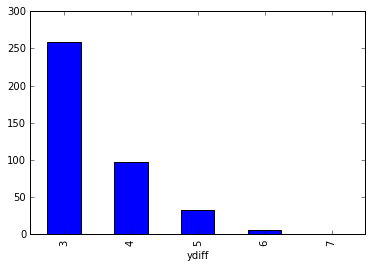

In [45]:
bStudentsS1toS6_grp = bStudentsS1toS6.groupby(bStudentsS1toS6.ydiff)
bStudentsS1toS6_grp.size().plot.bar()
bStudentsS1toS6_grp.size()

We don't see many more things than what the 'described()' function showed, only the large amount of people having graduated in the minimal time.

The next step is to split the students by their gender.

In [46]:
bStudentsByGender = bStudentsS1toS6.groupby(bStudentsS1toS6.civility)
bStudentsByGender.describe()

ydiff      year_S1      year_S6
civility                                            
Madame   count   29.000000    29.000000    29.000000
         mean     3.310345  2010.620690  2013.931034
         std      0.541390     2.060059     2.170106
         min      3.000000  2007.000000  2010.000000
         25%      3.000000  2009.000000  2012.000000
         50%      3.000000  2011.000000  2014.000000
         75%      4.000000  2012.000000  2016.000000
         max      5.000000  2014.000000  2017.000000
Monsieur count  368.000000   368.000000   368.000000
         mean     3.480978  2010.475543  2013.956522
         std      0.745316     2.029604     2.017164
         min      3.000000  2007.000000  2010.000000
         25%      3.000000  2009.000000  2012.750000
         50%      3.000000  2011.000000  2014.000000
         75%      4.000000  2012.000000  2016.000000
         max      7.000000  2014.000000  2017.000000

Nothing significant to report here, only that most of the graduated students are men (368 against 29).

Mean:
civility
Madame      3.310345
Monsieur    3.480978
Name: ydiff, dtype: float64
STD:
civility
Madame      0.541390
Monsieur    0.745316
Name: ydiff, dtype: float64


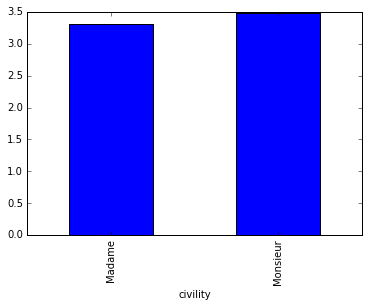

In [47]:
bStudentsByGender['ydiff'].mean().plot.bar()
print("Mean:\n" + str(bStudentsByGender['ydiff'].mean()))
print("STD:\n" + str(bStudentsByGender['ydiff'].std()))

Using a boxplot, we can barely see any difference. Except for an outlier in the male category

OrderedDict([('Madame',
              <matplotlib.axes._subplots.AxesSubplot at 0x249e65025c0>),
             ('Monsieur',
              <matplotlib.axes._subplots.AxesSubplot at 0x249e676f2b0>)])

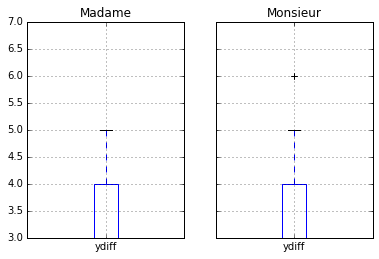

In [48]:
bStudentsByGender.boxplot(column ='ydiff', return_type='axes' )

The best test to determine whether the difference in distribution is actually different or not is the Wilcoxon-Mann-Whitney test. For two reasons :
- This isn't a normal distribution (peak will be at 3, but you can't go left, only right)
- We aren't comparing paired samples

We will use it now with the two tailed test because we're looking for significant differences in any direction

In [49]:
bStudentsByGender.apply(lambda t: stats.mannwhitneyu(t.ydiff, t.ydiff, alternative = 'two-sided').pvalue)

civility
Madame      0.992033
Monsieur    0.999836
dtype: float64

As we can see we are very far from a significant p-value.

So we can conclude that there is no significant difference here, only that female students are a bit better and more uniformly distributed, but the size of the sample is too low to establish conclusions.

Now let's try to do the same thing for the Master students. We will use the same query fuction 

In [50]:
frames = []
for year in range(2007, 2017):
    for semester in range (1, 4):
        if(semester % 2 == 0 ):
            season="de printemps"
        else:
            season="d'automne"
            
        df = query_epfl("Informatique", year,year+1, "Master semestre", semester, season)
        df['year'] = year
        df['semester'] = semester
        #we use semester as first index for simplicity of use in next part
        df.set_index(['semester', 'year', 'sciper'], drop=False, append=False, inplace=True)
        if (not df.index.is_unique):
            print("Error: non unique index in year:" + str(year) + "-" + str(year+1) + ", semester:" + str(semester) + ", season:" + str(season))
            
        frames.append(df)

msStudents = pd.concat(frames)
msStudents.shape

(2716, 13)

And again just a quick check

In [51]:
msStudents.index.is_unique

True

In [52]:
msStudents.head()

civility                       name  \
semester year sciper                                        
1        2007 153066  Monsieur  Aeberhard François-Xavier   
              180027    Madame              Agarwal Megha   
              152232  Monsieur         Anagnostaras David   
              177395  Monsieur              Auroux Damien   
              161970  Monsieur             Awalebo Joseph   

                      bachelor_orientation  master_orientation specialisation  \
semester year sciper                                                            
1        2007 153066                   NaN                 NaN            NaN   
              180027                   NaN                 NaN            NaN   
              152232                   NaN                 NaN            NaN   
              177395                   NaN                 NaN            NaN   
              161970                   NaN                 NaN            NaN   

                      optional_spec minor   status exchange_type  \
semester year sciper                                               
1        2007 153066            NaN   NaN  Présent           NaN   
              180027            NaN   NaN  Présent           NaN   
              152232            NaN   NaN  Présent           NaN   
              177395            NaN   NaN  Présent           NaN   
              161970            NaN   NaN  Présent           NaN   

                     exchange_school  sciper  year  semester  
semester year sciper                                          
1        2007 153066             NaN  153066  2007         1  
              180027             NaN  180027  2007         1  
              152232             NaN  152232  2007         1  
              177395             NaN  177395  2007         1  
              161970             NaN  161970  2007         1

In [53]:
msStudentsS1toS2 = pd.merge(msStudents.loc[1], msStudents.loc[2], how='inner', on=['civility', 'name', 'sciper'], suffixes=('_S1', '_S2'))
msStudentsS1toS2 = msStudentsS1toS2[['civility', 'sciper', 'minor_S2' , 'specialisation_S2','year_S1', 'year_S2']] #only retain the important fields
# We only get the minor and spec. info form the second semester because it is the most recent data and the time when most people make the slection

#Here we will make an assumption that all people that are in semester 2 and have not selected an minor or spec, 
#decided to take the 90 ECTS master and a probaly doing a master project
msStudentsS1toS2 = msStudentsS1toS2[pd.isnull(msStudentsS1toS2['minor_S2']) & pd.isnull(msStudentsS1toS2['specialisation_S2'])]



#We will calculate the study time in months 
msStudentsS1toS2['year_S2'] += 1 #again, we do this because a spring semester in (2015-2016) will count as 2015 but the actual year is 2016
msStudentsS1toS2['months'] = (msStudentsS1toS2['year_S2'] - msStudentsS1toS2['year_S1']) * 12 + 6

msStudentsS1toS2= msStudentsS1toS2.groupby('sciper', group_keys=False).apply(lambda x: x.ix[x.months.idxmax()])
msStudentsS1toS2.set_index('sciper', inplace=True)

In [54]:
msStudentsS1toS2

,civility,minor_S2,specialisation_S2,year_S1,year_S2,months
sciper,,,,,,
146330,Monsieur,NaN,NaN,2007,2008,18
146929,Monsieur,NaN,NaN,2007,2008,18
147008,Monsieur,NaN,NaN,2011,2013,30
153066,Monsieur,NaN,NaN,2007,2009,30
153746,Monsieur,NaN,NaN,2007,2008,18
153762,Monsieur,NaN,NaN,2008,2010,30
154080,Monsieur,NaN,NaN,2007,2008,18
154573,Madame,NaN,NaN,2007,2008,18
154643,Monsieur,NaN,NaN,2007,2008,18


In [55]:
msStudentsS1toS2.groupby('months').count().civility

months
6      23
18    404
30     85
42      4
Name: civility, dtype: int64

In [56]:
msStudentsS1toS2.months.mean()

19.627906976744185